## Train classifier by layers

This notebook trains a classifier that operates in two layers:
- First we use a SVM classifier to label utterances with high degree of certainty.
- Afterwards we use heuristics to complete the labeling

### Import and path definition

In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import sys

root_path = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
sys.path.append(root_path)

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from src import phase_classification as pc

data_path = os.path.join(root_path,'data')
tables_path = os.path.join(data_path,'tables')

### Load data

In [2]:
WITH_STEMMING = True
#REMOVE_STOPWORDS = True
SEED = 10
NUM_TOPICS = 60
random.seed(SEED)

In [3]:
file_name = '[train]IBL_topic_distribution_by_utterance_minimum_5_words_with_stemming_{}_{}.xlsx'.format(WITH_STEMMING,NUM_TOPICS)
df_data = pd.read_excel(os.path.join(tables_path,'train',file_name))

In [4]:
df_data.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 60,phase,phase_1,phase_2,phase_3,phase_4,phase_5,utterance,length utterance,utterance_relative_time
0,0.009546,0.012683,0.006349,0.005774,0.003684,0.005008,0.004698,0.008680,0.012694,0.015815,...,0.011693,1,1,0,0,0,0,SATUNNAINEN,0.000000,0.000000
1,0.102344,0.009047,0.004529,0.004119,0.002628,0.003573,0.003351,0.006192,0.009057,0.011282,...,0.008342,1,1,0,0,0,0,siel QUESTION_SYMBOL onks oo palo,0.065574,0.010417
2,0.102352,0.009047,0.004529,0.004119,0.002628,0.003573,0.003351,0.006192,0.009055,0.011302,...,0.008342,1,1,0,0,0,0,no tää varm muutu,0.049180,0.017361
3,0.005717,0.007596,0.003803,0.077458,0.002207,0.003000,0.002814,0.005199,0.007603,0.009472,...,0.007004,1,1,0,0,0,0,aja T_ ATOMI ehtiny törm ton ver,0.098361,0.020833
4,0.111640,0.004865,0.002435,0.002215,0.001413,0.001921,0.001802,0.003329,0.004869,0.006066,...,0.004486,1,1,0,0,0,0,ton ver ai pitä muute kato sil taas oo lask to...,0.213115,0.027778


In [5]:
the_keys = list(set(df_data['phase']))
total_samples = 0
class_samples = {}
for key in the_keys:
    n = list(df_data.phase.values).count(key)
    #print("key {}, total {}".format(key,n))
    total_samples += n
    class_samples[key] = n
print(total_samples)
for key in the_keys:
    print("key {}, samples: {}, prop: {}".format(key,class_samples[key],round(class_samples[key]*1.0/total_samples,2)))

1600
key 1, samples: 403, prop: 0.25
key 2, samples: 175, prop: 0.11
key 3, samples: 406, prop: 0.25
key 4, samples: 62, prop: 0.04
key 5, samples: 554, prop: 0.35


### split data

In [6]:
filter_rows = list(range(60))+[67,68]
row_label = 60

In [8]:
dfs_train,dfs_val = pc.split_df_discussions(df_data,.2,SEED)
X_train,y_train = pc.get_joined_data_from_df(dfs_train,filter_rows,row_label)
X_val,y_val = pc.get_joined_data_from_df(dfs_val,filter_rows,row_label)
len(X_train)

1328

In [19]:
dfs_all,_ = pc.split_df_discussions(df_data,.0,SEED)
X_all,y_all = pc.get_joined_data_from_df(dfs_all,filter_rows,row_label)

### Classify first layer

In [9]:
class_weight = {}
for key in the_keys:
    class_weight[key] = 1000.0/class_samples[key]

In [10]:
svc = SVC(kernel='linear',random_state=SEED,max_iter=3000,probability=True,class_weight=class_weight)#
svc.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svc.score(X_val, y_val)))

Accuracy of SVM classifier on training set: 0.40
Accuracy of SVM classifier on test set: 0.33


In [11]:
pred = svc.predict(X_val)
labels = ["Phase {}".format(i) for i in range(1,6)]
df = pd.DataFrame(confusion_matrix(y_val, pred),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
#print(" ")
print(classification_report(y_val, pred))
df

              precision    recall  f1-score   support

           1       0.68      0.60      0.64       101
           2       0.09      0.56      0.15         9
           3       0.30      0.05      0.08        63
           4       0.04      1.00      0.08         3
           5       0.51      0.20      0.29        96

   micro avg       0.33      0.33      0.33       272
   macro avg       0.32      0.48      0.25       272
weighted avg       0.51      0.33      0.36       272



,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,61,20,3,10,7
Phase 2,0,5,0,3,1
Phase 3,16,15,3,19,10
Phase 4,0,0,0,3,0
Phase 5,13,18,4,42,19


### Find threshold

Look for the distance to the second max

In [12]:
pred_val = svc.predict_proba(X_val)
prob_pred = [v[int(y_val[i]-1)] for i,v in enumerate(pred_val)]

(array([16., 29., 45., 33., 24., 26., 24., 37., 28., 10.]),
 array([0.0293428 , 0.09870144, 0.16806009, 0.23741873, 0.30677738,
        0.37613602, 0.44549467, 0.51485331, 0.58421196, 0.6535706 ,
        0.72292925]),
 <a list of 10 Patch objects>)

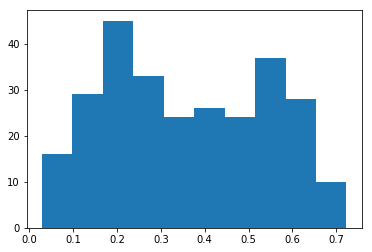

In [13]:
plt.hist(prob_pred)

In [14]:
tuple_winner_pred = [(np.max(v),prob_pred[i],np.max(v)==prob_pred[i]) for i,v in enumerate(pred_val)]
values_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==True]
values_not_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==False]
values_dist_not_ok = [v[0]-v[1] for i,v in enumerate(tuple_winner_pred) if v[2]==False]

(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 3., 4., 2., 9., 2., 3.,
        3., 2., 5., 5., 2., 2., 2., 5., 6., 9., 5., 2., 6., 9., 4., 5., 2.,
        4., 3., 2., 2., 3., 2., 3., 3., 4., 1., 2., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ,
        0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41,
        0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52,
        0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63,
        0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74,
        0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
        0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94]),
 <a list of 74 Patch objects>)

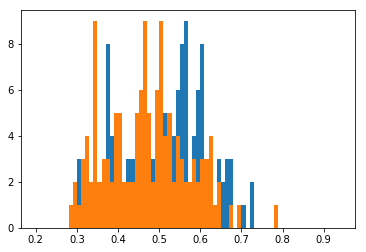

In [16]:
plt.hist(values_ok,np.arange(0.2,.95,.01))
plt.hist(values_not_ok,np.arange(0.2,.95,.01))

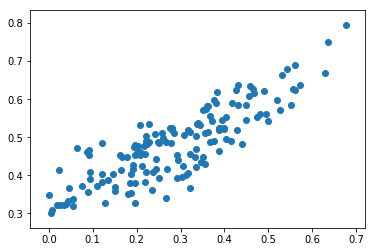

In [17]:
plt.scatter(values_dist_not_ok,values_not_ok)

Define Threshold 

In [31]:
t = 0.55

In [32]:
output_first_layer = pc.first_layer_classifier(X_all,t,svc)
comparison = list(zip(output_first_layer,y_all))

In [33]:
df_data['first_layer'] = output_first_layer

### Second layer

In [34]:
pred_val = svc.predict_proba([X_all[3]])
pred_val

array([[0.64023086, 0.15611294, 0.08063534, 0.00136591, 0.12165495]])

In [35]:
second_layer = pc.second_layer_classifier_max_border(X_all,df_data,svc)

In [36]:
df_data['second_layer'] = second_layer
df_data.to_excel(os.path.join(tables_path,'[second_layer]'+file_name))

In [37]:
second_aux = []
y_all_aux = []
for i,e in enumerate(second_layer):
    if e!=-1:
        second_aux.append(second_layer[i])
        y_all_aux.append(y_all[i])
confusion_matrix(y_all_aux, second_aux)

array([[267,   0,  70,   0,  66],
       [ 33,   0,  55,   0,  87],
       [ 60,   0, 228,   0, 118],
       [  0,   0,   6,   1,  55],
       [ 92,   0, 133,   0, 329]], dtype=int64)

In [38]:
"Number of not predicted {}".format(second_layer.count(-1))

'Number of not predicted 0'

In [39]:
df = pd.DataFrame(confusion_matrix(y_all_aux, second_aux),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
print(classification_report(y_all_aux, second_aux))
df

              precision    recall  f1-score   support

           1       0.59      0.66      0.62       403
           2       0.00      0.00      0.00       175
           3       0.46      0.56      0.51       406
           4       1.00      0.02      0.03        62
           5       0.50      0.59      0.54       554

   micro avg       0.52      0.52      0.52      1600
   macro avg       0.51      0.37      0.34      1600
weighted avg       0.48      0.52      0.48      1600



C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,267,0,70,0,66
Phase 2,33,0,55,0,87
Phase 3,60,0,228,0,118
Phase 4,0,0,6,1,55
Phase 5,92,0,133,0,329


In [40]:
with open(os.path.join(data_path,'classifier_svm_single_best_of_two.pickle'),'wb') as f:
    pickle.dump(svc,f)

In [42]:
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_all, second_layer)))

Accuracy of SVM classifier on training set: 0.42
